# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Загрузка файла с даными и изучение общей информации. 

In [1]:
import pandas as pd # импортируем необходимые библиотеки для работы с данными
import numpy as np

In [2]:
#прочитаем файл с датасетом; поменяем несколько типов данных для уменьшения объема памяти 
df_start = pd.read_csv('/datasets/real_estate_data.csv', sep='\t',
                dtype={
                    'total_images': np.int8,
                    'rooms': np.int8,
                    'floor': np.int8
                })

In [3]:
pd.set_option('display.max_columns', None)
df_start.head()#выведем на экран первые 5 строк для ознакомения

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
df_start.info() #выведем на экран общую информацию

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int8   
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int8   
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int8   
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [5]:
df_start = df_start.rename({'cityCenters_nearest': 'city_centers_nearest'}, axis=1)#переименуем столбец в соответствии со snake_case

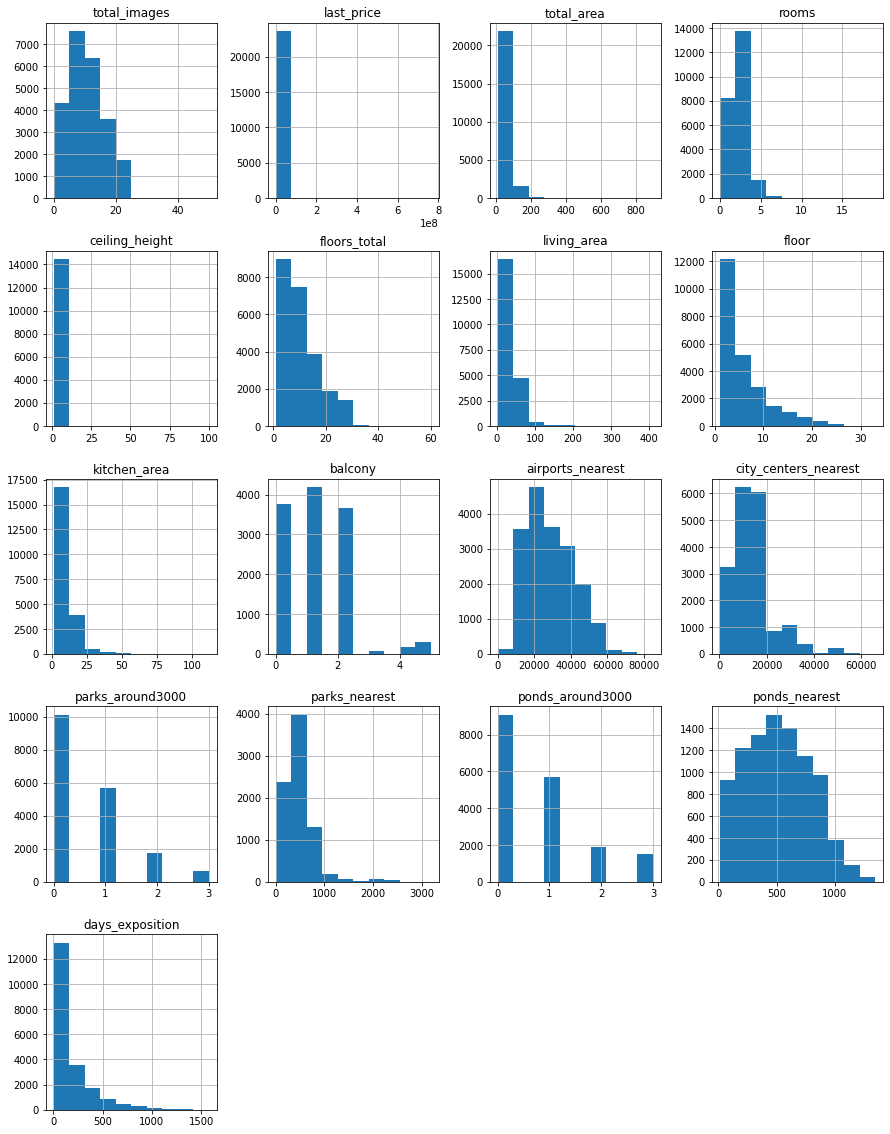

In [6]:
df_start.hist(figsize=(15,20));#построим ознакомительные гистограммы по каждому столбцу

Из представленных диаграмм можно сделать некоторые выводы:
- в столбцах с данными, заполненными владельцами объявлений, присутствуют аномальные значения;
- больше всего объявлений - о продаже 1-4х комнатных квартир, с общей площадью до 100-150 кв м, по цене до 10 млн рублей. Однако, есть и выбросы - очень дорогие дорогие объекты, заметно выделяющиеся на фоне остальных объявлений.

### Предобработка данных

In [7]:
df_start.isna().sum() #оценим количество пропусков в каждой колонке

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

- Пропуски в столбце 'balcony' заполним нулями, так как, вероятно, наличие балконов не указано по причине их отсутствия. 
- Пропуски в столбце 'is_apartment' заполним 'False', скорее всего объявления с такими пропусками - это объявления о продаже обычных квартир.
- Удалим все строки с пропусками в 'locality_name', таких строк немного(49), к тому же, объявления без указания населенного пункта не помогут исследованию.

In [8]:
df_start['balcony'] = df_start['balcony'].fillna(0) 

In [9]:
df_start['is_apartment'] = df_start['is_apartment'].fillna(False)

In [10]:
df = df_start.dropna(subset=['locality_name']).reset_index(drop=True)# убрали объявления без указания города

Теперь займемся поиском неявных дубликатов в названиях населенных пунктов 'locality_name'. Для этого выведем и отсортируем список уникальных имен всех населенных пунктов.

In [11]:
df['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

In [12]:
len(df['locality_name'].unique()) # количество уникальных имен населенных пунктов

364

1) Заменим "ё" на "е" в некоторых названиях населенных пунктов, чтобы убрать неявные дубликаты.

2) Поселок Мурино в 2019г стал городом-спутником Санкт-Петербурга, как и деревня Кудрово(в 2018г). Оставим и те. и другие обозначения.

   Среди неявных дубликатов также присутствуют:
   - 'поселок Рябово' - 'поселок городского типа Рябово',
   - 'поселок городского типа Большая Ижора'-'городской поселок Большая Ижора',
   - 'поселок Коммунары'-город Коммунар,
   - 'поселок городского типа Мга'-'городской поселок Мга',
   - 'поселок городского типа Назия' - 'городской посёлок Назия',
   - 'поселок городского типа Рощино' - 'городской поселок Рощино',
   - 'поселок городского типа Советский' - 'городской поселок Советский'
   - 'поселок при железнодорожной станции Вещево' - 'поселок станции Вещево'
   - 'поселок при железнодорожной станции Приветнинское' - 'поселок станции Приветнинское'

In [13]:
df['locality_name'] = df['locality_name'].str.replace('ё','е')

In [14]:
df = df.replace({'locality_name':{
    'поселок Рябово':'поселок городского типа Рябово',
    'городской поселок Большая Ижора':'поселок городского типа Большая Ижора',
    'поселок Коммунары':'Коммунар',
    'городской поселок Мга':'поселок городского типа Мга',
    'городской посёлок Назия':'поселок городского типа Назия',
    'городской поселок Рощино':'поселок городского типа Рощино',
    'городской поселок Советский':'поселок городского типа Советский',
    'поселок при железнодорожной станции Вещево':'поселок станции Вещево',
    'поселок при железнодорожной станции Приветнинское':'поселок станции Приветнинское'
}})

In [15]:
len(df['locality_name'].unique()) #после обработки данных число уникальных имен уменьшилось

322

In [16]:
df.duplicated().sum() #проверим данные на наличие дубликатов

0

Теперь посмотрим на список уникальных значений высоты потолка:

In [17]:
df.ceiling_height.unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

В данном списке есть аномально высокие и аномально низкие значения. Часть из них удалим, часть- заменим на реальные значения. Например, 26. - это вероятно 2.6, 22.6 - 2.6, и т.д. Такие значения возникли скорее всего по ошибке, при невнимательном заполнении объявлений о продаже.

In [18]:
height=[100.,20.,1.,8.,14.,1.2,2.,8.3,6.,10.3,1.75]
for i in height:
    df = df.loc[(df['ceiling_height']!=i )]   

In [19]:
df = df.replace({'ceiling_height':{25. :2.5, 27. :2.7, 32. :3.2, 24. :2.4, 26. :2.6, 22.6:2.6, 27.5:2.75}})
df.ceiling_height.unique() 

array([2.7 ,  nan, 3.03, 2.5 , 2.67, 2.56, 3.05, 2.75, 2.6 , 2.9 , 2.8 ,
       2.55, 3.  , 2.65, 3.2 , 2.61, 3.25, 3.45, 2.77, 2.85, 2.64, 2.57,
       4.15, 3.5 , 3.3 , 2.71, 4.  , 2.47, 2.73, 2.84, 3.1 , 2.34, 3.4 ,
       3.06, 2.72, 2.54, 2.51, 2.78, 2.76, 2.58, 3.7 , 2.52, 5.2 , 2.87,
       2.66, 2.59, 2.45, 3.6 , 2.92, 3.11, 3.13, 3.8 , 3.15, 3.55, 3.16,
       3.62, 3.12, 2.53, 2.74, 2.96, 2.46, 5.3 , 5.  , 2.79, 2.95, 4.06,
       2.94, 3.82, 3.54, 3.53, 2.83, 4.7 , 2.4 , 3.38, 3.01, 5.6 , 3.65,
       3.9 , 3.18, 3.35, 2.3 , 3.57, 2.48, 2.62, 2.82, 3.98, 2.63, 3.83,
       3.52, 3.95, 3.75, 2.88, 3.67, 3.87, 3.66, 3.85, 3.86, 4.19, 3.24,
       4.8 , 4.5 , 4.2 , 3.36, 3.08, 3.68, 3.07, 3.37, 3.09, 3.26, 3.34,
       2.81, 3.44, 2.97, 3.14, 4.37, 2.68, 3.22, 3.27, 4.1 , 2.93, 3.46,
       3.47, 3.33, 3.63, 3.32, 2.98, 2.86, 3.17, 4.4 , 3.28, 3.04, 4.45,
       5.5 , 3.84, 3.23, 3.02, 3.21, 3.43, 3.78, 4.3 , 3.39, 2.69, 3.31,
       4.65, 3.56, 2.2 , 3.51, 3.93, 3.42, 2.99, 3.

Пропуски в значениях высоты потолка заполним средним значением(так как разброс значений небольшой) по данным высоты потолка домов каждого населенного пункта:

In [20]:
for i in df['locality_name'].unique():
    # на каждом шаге цикла с помощью атрибута loc выбираем строки,
    # в которых в locality_name текущее название нас.пункта и есть пропуски в ceiling_height 
    df.loc[(df['locality_name'] == i) & (df['ceiling_height'].isna()), 'ceiling_height'] = \
    df.loc[(df['locality_name'] == i), 'ceiling_height'].mean()

In [21]:
df['ceiling_height'] = df['ceiling_height'].round(2) #округлим значения высоты потолка до сотых долей

In [22]:
#Там, где из-за пропусков невозможно было вычислить среднюю высоту потолка по нас.пункту, найдем среднюю от средней высоты  
#по всем населенным пунктам и округлим до сотых долей
ceiling_mean = (df.groupby('locality_name')['ceiling_height'].mean()).mean().round(2)
ceiling_mean

2.61

In [23]:
for i in df['locality_name'].unique():
    # на каждом шаге цикла с помощью атрибута loc выбираем строки,
    # в которых в locality_name текущее название нас.пункта и есть пропуски в ceiling_height 
    df.loc[(df['locality_name'] == i) & (df['ceiling_height'].isna()), 'ceiling_height'] = ceiling_mean

Перейдем к изучению столбца с данными о количестве этажей в доме:

In [24]:
df['floors_total'].unique() # изучим все уникальные значения числа этажей в домах

array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., nan, 20.,
       28., 36., 21., 35., 34., 60.,  1., 29., 33., 52.])

In [25]:
df = df.loc[(df['floors_total']!=52.) & (df['floors_total']!=60.)] # удалим значения 52 и 60, так как максимальное число  
# этажей в домах Санкт-Петербурга - 36

In [26]:
# удалим пропущенные значения числа этажей в доме(таких значений немного, всего 86)
df= df.dropna(subset=['floors_total']).reset_index(drop=True)

Для заполнения пропусков в "living_area" и "kitchen_area" исследуем столбец с общей площадью квартир "total_area", разобьем все объявления на категории по площади квартир, вычислим среднее для столбцов "living_area" и "kitchen_area" в кажой категории и заполним медианным значением пропуски в этих столбцах.

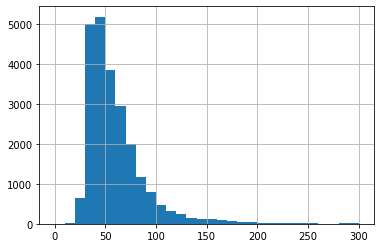

In [27]:
df.total_area.hist(bins=30, range=(0,300)); #строим гистограмму по общим площадям квартир

In [28]:
def categorize_total_area(total): #функция для разбиения значений общей площади на категории
    if total < 30:
        return 'F'
    if total >= 30 and total< 60:
        return 'E'
    if total >= 60 and total < 90:
        return 'D'
    if total>= 90 and total < 120:
        return 'C'
    if total>= 120 and total < 200:
        return 'B'
    return 'A'

In [29]:
 df['total_area_category'] = df['total_area'].apply(categorize_total_area)

In [30]:
df.pivot_table(
    index='total_area_category', 
    values=['living_area','kitchen_area'], 
    aggfunc='median'
) #построим сводную таблицу медианных значений площадей кухни и общей площади в зависимости от категорий

,kitchen_area,living_area
total_area_category,,
A,26.0,159.20
B,17.8,83.20
C,14.2,58.00
D,10.4,42.75
E,8.3,21.50
F,6.0,16.20


In [31]:
for i in df['total_area_category'].unique():
    # на каждом шаге цикла с помощью атрибута loc выбираем строки,
    # в которых в total_area_category текущее название категории и есть пропуски в living_area 
    df.loc[(df['total_area_category'] == i) & (df['living_area'].isna()), 'living_area'] = \
    df.loc[(df['total_area_category'] == i), 'living_area'].median()

In [32]:
 for i in df['total_area_category'].unique():
    # на каждом шаге цикла с помощью атрибута loc выбираем строки,
    # в которых в total_area_category текущее название категории и есть пропуски в kitchen_area 
    df.loc[(df['total_area_category'] == i) & (df['kitchen_area'].isna()), 'kitchen_area'] = \
    df.loc[(df['total_area_category'] == i), 'kitchen_area'].median()

In [33]:
df = df.query('(kitchen_area+living_area)<total_area') # оставим только те объявления, в которых выполняется проверка:
#площадь кухни + жилая площадь < общая площадь

In [34]:
df.info()#посмотрим, сколько строк осталось после фильтрации


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23286 entries, 0 to 23539
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23286 non-null  int8   
 1   last_price            23286 non-null  float64
 2   total_area            23286 non-null  float64
 3   first_day_exposition  23286 non-null  object 
 4   rooms                 23286 non-null  int8   
 5   ceiling_height        23286 non-null  float64
 6   floors_total          23286 non-null  float64
 7   living_area           23286 non-null  float64
 8   floor                 23286 non-null  int8   
 9   is_apartment          23286 non-null  bool   
 10  studio                23286 non-null  bool   
 11  open_plan             23286 non-null  bool   
 12  kitchen_area          23286 non-null  float64
 13  balcony               23286 non-null  float64
 14  locality_name         23286 non-null  object 
 15  airports_nearest   

Пропуски в колонках расстояния до центра и до аэропорта (там,где это возможно) заполним средним расстоянием до центра и аэропорта по населенным пунктам. 

In [35]:
df.pivot_table(
    index='locality_name',
    values=['airports_nearest', 'city_centers_nearest'],
    aggfunc='mean'
)

,airports_nearest,city_centers_nearest
locality_name,,
Зеленогорск,73300.250000,54617.583333
Колпино,26370.520833,32108.282738
Красное Село,26621.427746,30046.144509
Кронштадт,67466.138298,49192.617021
Ломоносов,48308.280303,50739.969697
Павловск,21053.342105,33206.921053
Петергоф,40182.055276,35425.874372
Пушкин,16456.328804,28754.250681
Санкт-Петербург,28055.092549,11591.255508


In [36]:
 for i in df['locality_name'].unique():
    # на каждом шаге цикла с помощью атрибута loc выбираем строки,
    # в которых в locality_name текущее название нас.пункта и есть пропуски в city_centers_nearest
    df.loc[(df['locality_name'] == i) & (df['city_centers_nearest'].isna()), 'city_centers_nearest'] = \
    df.loc[(df['locality_name'] == i), 'city_centers_nearest'].mean()

In [37]:
for i in df['locality_name'].unique():
    # на каждом шаге цикла с помощью атрибута loc выбираем строки,
    # в которых в locality_name текущее название нас.пункта и есть пропуски в airports_nearest
    df.loc[(df['locality_name'] == i) & (df['airports_nearest'].isna()), 'airports_nearest'] = \
    df.loc[(df['locality_name'] == i), 'airports_nearest'].mean()

In [38]:
# посмотрим, в скольких населенных пунктах остались пропуски 
len(df[df['city_centers_nearest'].isna()]['locality_name'].unique())

297

Проверим, сколько пропусков осталось после заполнения:

In [39]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5325
city_centers_nearest     5325
parks_around3000         5393
parks_nearest           15333
ponds_around3000         5393
ponds_nearest           14335
days_exposition          3139
total_area_category         0
dtype: int64

В столбцах расстояния до центра города и до аэропорта 'city_centers_nearest', 'airports_nearest' осталось еще достаточно много пропусков. Хотя такие данные могут помочь нашему исследованию. Попробуем сами заполнить эти столбцы. На основании данных Яндекс.Карты найдем расстояния от основных городов и городских поселков до Санкт-Петербурга: 

In [40]:
df.query('city_centers_nearest.isna()')['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Ивангород', 'Каменногорск', 'Кингисепп',
       'Кириши', 'Кировск', 'Коммунар', 'Кудрово', 'Лодейное Поле',
       'Луга', 'Любань', 'Мурино', 'Никольское', 'Новая Ладога',
       'Отрадное', 'Пикалево', 'Подпорожье', 'Приморск', 'Приозерск',
       'Светогорск', 'Сертолово', 'Сланцы', 'Сосновый Бор', 'Сясьстрой',
       'Тихвин', 'Тосно', 'Шлиссельбург', 'городской поселок Будогощь',
       'городской поселок Виллози', 'городской поселок Лесогорский',
       'городской поселок Назия', 'городской поселок Новоселье',
       'городской поселок Павлово', 'городской поселок Свирьстрой',
       'городской поселок Федоровское', 'городской поселок Янино-1',
       'деревня Агалатово', 'деревня Аро', 'деревня Батово',
       'деревня Бегуницы', 'деревня Белогорка', 'деревня Большая Вруда',
       'деревня Большая Пустомержа', 'деревня Большие Колпаны',
       'деревня Большое Рейзино', 'деревня Б

In [41]:
#список расстояний от городов и поселков до центра и до ближашего аэропорта, взятые с Яндекс.Карты, в км
map = [
    254,83,137,27,135,159,48,154,175,134,171,53,56,18,229,147,96,22,54,132,41,223,279,132,149,185,37,182,99,144,221,65,54,
    67,197,35,181,73,70,29,49,75,248,142,46,16,44,26,84,80,75,100,123,293,360,74,83,46,300,184,47,168,28,74,182,41,75,91,76,
    39,56,57,64,54,32
      ]
airport = [
    257,75,139,46,155,178,32,148,194,131,151,55,39,27,235,131,85,47,39,135,39,268,281,151,174,204,56,179,95,146,226,50,56,
     61,188,33,186,70,71,32,47,78,245,146,50,20,45,23,82,86,72,105,120,290,353,80,87,45,297,180,51,166,24,77,185,43,74,90,77,
     33,54,58,62,52,30
          ]
cities = [
    'Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Ивангород', 'Каменногорск', 'Кингисепп',
       'Кириши', 'Кировск', 'Коммунар', 'Кудрово', 'Лодейное Поле',
       'Луга', 'Любань', 'Мурино', 'Никольское', 'Новая Ладога',
       'Отрадное', 'Пикалево', 'Подпорожье', 'Приморск', 'Приозерск',
       'Светогорск', 'Сертолово', 'Сланцы', 'Сосновый Бор', 'Сясьстрой',
       'Тихвин', 'Тосно', 'Шлиссельбург','поселок городского типа Большая Ижора', 'городской поселок Будогощь',
       'городской поселок Виллози', 'городской поселок Лесогорский',
       'поселок городского типа Мга', 'поселок городского типа Назия',
       'городской поселок Новоселье', 'городской поселок Павлово',
       'поселок городского типа Рощино', 'городской поселок Свирьстрой',
       'поселок городского типа Советский', 'городской поселок Федоровское',
       'городской поселок Янино-1', 'деревня Агалатово', 'деревня Аро',
       'деревня Батово', 'деревня Бегуницы', 'деревня Белогорка',
       'деревня Большая Вруда', 'деревня Большая Пустомержа','поселок городского типа Важины',
       'поселок городского типа Вознесенье',
       'поселок городского типа Вырица',
       'поселок городского типа Дружная Горка',
       'поселок городского типа Дубровка',
       'поселок городского типа Ефимовский',
       'поселок городского типа Кондратьево',
       'поселок городского типа Красный Бор',
       'поселок городского типа Кузнечное',
       'поселок городского типа Кузьмоловский',
       'поселок городского типа Лебяжье',
       'поселок городского типа Лесогорский',
       'поселок городского типа Рахья', 
       'поселок городского типа Рощино',
       'поселок городского типа Рябово',
       'поселок городского типа Сиверский',
       'поселок городского типа Тайцы', 
       'поселок городского типа Токсово',
       'поселок городского типа Ульяновка',
       'поселок городского типа Форносово',
       'поселок городского типа имени Морозова',
       'поселок городского типа имени Свердлова'
         ]
# в цикле присвоим данные значения исходному датасету(и переведем в метры)
i=0
for city in cities:
    df.loc[(df['locality_name'] == city), 'city_centers_nearest']= map[i]*1000
    df.loc[(df['locality_name'] == city), 'airports_nearest']= airport[i]*1000
    i+=1  



            

In [42]:
df.isna().sum() # после заполнения пропусков списком расстояний, число пропущенных значений заметно уменьшилось

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         2119
city_centers_nearest     2119
parks_around3000         5393
parks_nearest           15333
ponds_around3000         5393
ponds_nearest           14335
days_exposition          3139
total_area_category         0
dtype: int64

In [43]:
df.query('locality_name=="поселок городского типа Тайцы"')['city_centers_nearest']# проверим, правильно ли присвоились значения

1890     39000.0
3761     39000.0
5398     39000.0
9796     39000.0
12316    39000.0
21929    39000.0
Name: city_centers_nearest, dtype: float64

Все верно. От поселка Тайцы до центра Санкт-Петербурга 39км

Перйдем к столбцу 'days_exposition'. Пропуски здесь означают. что квартира еще не продана, заполнять не будем.

Пропуски в столбцах 'ponds_nearest' и 'parks_nearest' заполнять не будем, чтобы не исказить данные в процессе исследования.

In [44]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         2119
city_centers_nearest     2119
parks_around3000         5393
parks_nearest           15333
ponds_around3000         5393
ponds_nearest           14335
days_exposition          3139
total_area_category         0
dtype: int64

Проверим данные на наличие дубликатов:

In [45]:
df.duplicated().sum()

0

Поменяем типы данных некоторых столбцов. Это необходимо для упрощения расчетов в исследовании, построения графиков, ускорения работы с данными, а также, чтобы не допустить ошибок в расчетах.

In [46]:
df = df.astype({'balcony':'int8','floors_total':'int8','is_apartment':'bool'})

Рассмотрим столбец со стоимостью квартир 'last_price'. Для наглядного изображения аномалий построим boxplot()

In [47]:
import matplotlib.pyplot as plt 

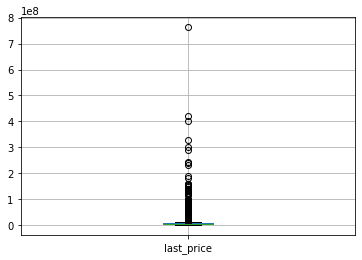

In [48]:
df.boxplot('last_price'); 

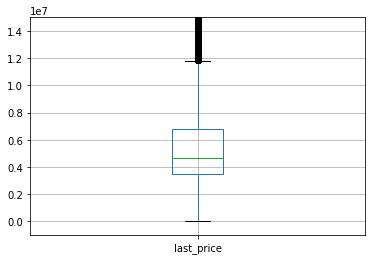

In [49]:
plt.ylim(-1e+06, 1.5e+07) # для лучшей визуализации изменим интервалы построения
df.boxplot('last_price'); 

In [50]:
(df['last_price']/1000000).describe()

count    23286.000000
mean         6.547714
std         10.893422
min          0.012190
25%          3.450000
50%          4.650000
75%          6.800000
max        763.000000
Name: last_price, dtype: float64

In [51]:
df.query('last_price==12190') # аномально низкая цена 12190р, посмотрим на это объявление

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category
8742,7,12190.0,109.0,2019-03-20T00:00:00,2,2.75,25,32.0,25,False,False,False,40.5,0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0,C


2-комнатная квартира в Санкт-Петербурге за 12190р - явная аномалия. Скорее всего имелось ввиду 12190 тыс.р. Удалим эту строку.
Также удалим строки с ценами выше верхнего 'уса' боксплота - выше 15 млн

In [52]:
df = df.query('last_price!=12190 & last_price<15000000')

Рассмотрим столбец с количеством комнат 'rooms'

In [53]:
df['rooms'].sort_values().unique() # выведем уникальные значения числа комнат

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int8)

In [54]:
df.query('rooms==0') 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category
144,1,2450000.0,27.0,2017-03-30T00:00:00,0,2.70,24,15.5,2,False,True,False,6.0,2,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,181.0,F
347,4,2320000.0,25.0,2017-09-27T00:00:00,0,2.72,14,17.0,1,False,False,True,6.0,0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.0,F
505,0,3375000.0,34.4,2017-03-28T00:00:00,0,2.63,26,24.3,19,False,False,True,8.3,1,поселок Парголово,53115.000000,19292.000000,0.0,NaN,1.0,593.0,430.0,E
604,2,1850000.0,25.0,2019-02-20T00:00:00,0,2.64,10,16.2,7,False,True,False,6.0,0,поселок Шушары,16078.476852,24270.076389,NaN,NaN,NaN,NaN,29.0,F
692,12,2500000.0,24.1,2017-12-01T00:00:00,0,2.75,25,17.5,21,False,True,False,6.0,0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,201.0,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23054,7,3200000.0,26.0,2017-09-01T00:00:00,0,2.76,25,18.0,16,False,True,False,6.0,0,Санкт-Петербург,11405.000000,13222.000000,0.0,NaN,1.0,623.0,14.0,F
23285,0,2500000.0,27.7,2017-09-28T00:00:00,0,2.70,24,18.0,4,False,False,True,6.0,2,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,4.0,F
23397,15,3350000.0,26.0,2018-09-07T00:00:00,0,2.76,19,16.2,8,False,True,False,6.0,0,Санкт-Петербург,18090.000000,17092.000000,0.0,NaN,2.0,112.0,31.0,F
23434,10,1450000.0,29.0,2017-11-11T00:00:00,0,2.61,9,18.0,8,False,False,True,6.0,2,Никольское,39000.000000,54000.000000,NaN,NaN,NaN,NaN,82.0,F


In [55]:
df.query('rooms==0 and (studio or open_plan)') # выведем только строки для квартир-студий или квартир открытого типа

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category
144,1,2450000.0,27.0,2017-03-30T00:00:00,0,2.70,24,15.5,2,False,True,False,6.0,2,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,181.0,F
347,4,2320000.0,25.0,2017-09-27T00:00:00,0,2.72,14,17.0,1,False,False,True,6.0,0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.0,F
505,0,3375000.0,34.4,2017-03-28T00:00:00,0,2.63,26,24.3,19,False,False,True,8.3,1,поселок Парголово,53115.000000,19292.000000,0.0,NaN,1.0,593.0,430.0,E
604,2,1850000.0,25.0,2019-02-20T00:00:00,0,2.64,10,16.2,7,False,True,False,6.0,0,поселок Шушары,16078.476852,24270.076389,NaN,NaN,NaN,NaN,29.0,F
692,12,2500000.0,24.1,2017-12-01T00:00:00,0,2.75,25,17.5,21,False,True,False,6.0,0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,201.0,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23054,7,3200000.0,26.0,2017-09-01T00:00:00,0,2.76,25,18.0,16,False,True,False,6.0,0,Санкт-Петербург,11405.000000,13222.000000,0.0,NaN,1.0,623.0,14.0,F
23285,0,2500000.0,27.7,2017-09-28T00:00:00,0,2.70,24,18.0,4,False,False,True,6.0,2,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,4.0,F
23397,15,3350000.0,26.0,2018-09-07T00:00:00,0,2.76,19,16.2,8,False,True,False,6.0,0,Санкт-Петербург,18090.000000,17092.000000,0.0,NaN,2.0,112.0,31.0,F
23434,10,1450000.0,29.0,2017-11-11T00:00:00,0,2.61,9,18.0,8,False,False,True,6.0,2,Никольское,39000.000000,54000.000000,NaN,NaN,NaN,NaN,82.0,F


Вывод: все квартиры с 0 комнат оказались квартирами-студиями или квартирами открытого плана, где нет четкого разделения на комнаты. Никаких аномалий нет.

Посмотрим на столбец с общей площадью квартир:

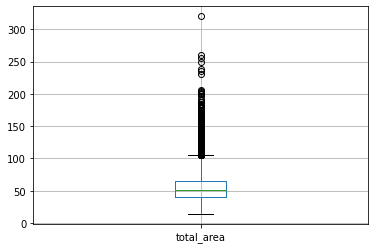

In [56]:
df.boxplot('total_area');

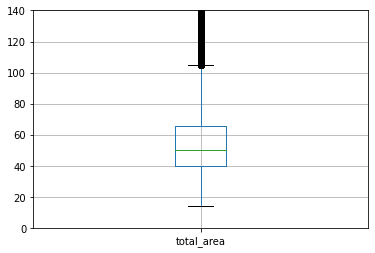

In [57]:
plt.ylim(0,140) # для наглядности изменим интервал построения
df.boxplot('total_area');

In [58]:
df['total_area'].describe()

count    22063.000000
mean        55.266240
std         21.735195
min         14.000000
25%         39.800000
50%         50.400000
75%         65.800000
max        320.000000
Name: total_area, dtype: float64

In [59]:
df = df.query('total_area < 140') # оставим только квартиры общей площадью менее 140 кв м

Изучим на аномалии столбец с жилой площадью квартир "living_area"

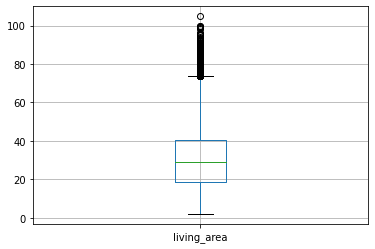

In [60]:
df.boxplot('living_area');

In [61]:
df['living_area'].describe()

count    21940.000000
mean        31.116063
std         13.921331
min          2.000000
25%         18.700000
50%         29.100000
75%         40.700000
max        104.800000
Name: living_area, dtype: float64

Минимальная жилая площадь - 2кв м, явная аномалия. Минимально допустимая норма жилой площади - 14 кв м

In [62]:
df = df.query('14 <= living_area <= 90')

In [63]:
df.shape[0]/df_start.shape[0] # удаленных данных не более 10% от общего объема

0.9118106249208827

### Добавление в таблицу новых столбцов

In [64]:
df['price_meter'] = (df['last_price']/df['total_area']).round(2) #цена за квадратный метр

Для работы с датами публикаций переведем тип данных столбца с датами к типу datetime64:

In [65]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%d')

In [66]:
df['weekday'] = df['first_day_exposition'].dt.weekday #номер дня недели публикации

In [67]:
df['month'] = df['first_day_exposition'].dt.month #месяц публикации

In [68]:
df['year'] = df['first_day_exposition'].dt.year #год публикации

In [69]:
#функция для категоризации этажей по типам: "первый","последний","другой"
def categorize_floor(row):
    floor = row['floor']
    total = row['floors_total']
    if floor == 1:
        return 'первый'
    if floor == total:
        return 'последний'
    else:
        return 'другой'

In [70]:
df['floor_type'] = df.apply(categorize_floor, axis=1)

In [71]:
#столбец с расстояниями до центра города, в км
df['centers'] = (df['city_centers_nearest']/1000).round()


### Исследовательский анализ данных

#### Изучение параметров объектов

#####  Анализ общей площади квартир 'total_area'

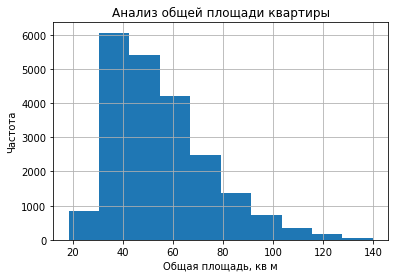

In [72]:
df['total_area'].hist()
plt.title('Анализ общей площади квартиры')
plt.xlabel('Общая площадь, кв м')
plt.ylabel('Частота');

У гистограммы очень длинный хвост, то есть в объявлениях встречаются квартиры с внушительными площадями(800-900 кв м).
Добавим в график диапазон range(), чтобы более детально рассмотреть распределение площадей квартир в объявлениях.

In [73]:
df['total_area'].describe()

count    21609.000000
mean        54.831252
std         19.878248
min         18.400000
25%         40.000000
50%         50.600000
75%         65.600000
max        139.800000
Name: total_area, dtype: float64

 Из полученной гистограммы делаем выводы: 
- распределение не симметрично, есть выбросы в сторону увеличения квадратуры общей площади;
- наиболее популярными являются квартиры общей площадью 40-65 кв м

##### Анализ жилой площади квартир 'living_area'

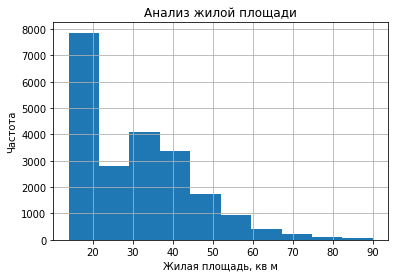

In [74]:
df['living_area'].hist()
plt.title('Анализ жилой площади')
plt.xlabel('Жилая площадь, кв м')
plt.ylabel('Частота');

In [75]:
df['living_area'].describe()

count    21609.000000
mean        31.318876
std         13.667523
min         14.000000
25%         19.000000
50%         29.500000
75%         41.000000
max         90.000000
Name: living_area, dtype: float64

- средняя жилая площадь квартир - 19 - 41 кв м

##### Анализ площади кухни 'kitchen_area'

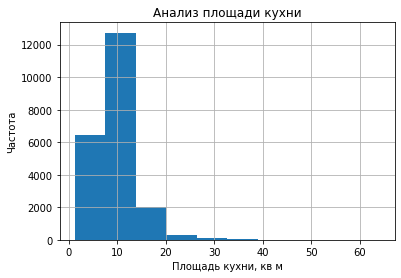

In [76]:
df['kitchen_area'].hist()
plt.title('Анализ площади кухни')
plt.xlabel('Площадь кухни, кв м')
plt.ylabel('Частота');

In [77]:
df['kitchen_area'].describe()

count    21609.000000
mean         9.665163
std          3.916447
min          1.300000
25%          7.000000
50%          9.000000
75%         11.000000
max         64.000000
Name: kitchen_area, dtype: float64

- минимальная площадь кухни 1,3 кв м - аномально маленькая; 
- в среднем, площадь кухни в квартирах составляет 9 кв м, квартиры с большей площадью кухни, скорее всего, относятся к новостройкам
- в дальнейших исследованиях ограничимся интервалом 5-25 кв м 

##### Анализ стоимости объекта 'last_price'

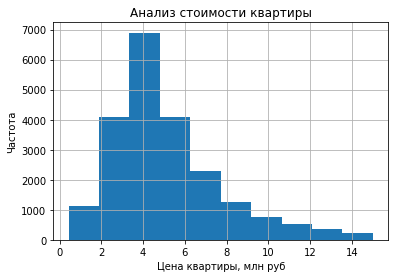

In [78]:
(df['last_price']/1000000).hist()
plt.title('Анализ стоимости квартиры')
plt.xlabel('Цена квартиры, млн руб')
plt.ylabel('Частота');

In [79]:
(df['last_price']/1000000).describe()

count    21609.000000
mean         5.125560
std          2.627399
min          0.430000
25%          3.400000
50%          4.500000
75%          6.285000
max         14.999999
Name: last_price, dtype: float64

 - минимальная цена квартиры -430000р - цена, характерная для наиболее отдаленных от центра деревень и поселков
 - самый популярный сегмент цен - 3,4 - 6,5 млн руб

##### Анализ количества комнат 'rooms'

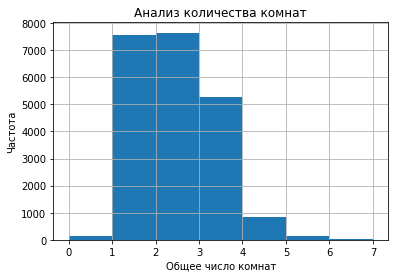

In [80]:
df['rooms'].hist(bins=7)
plt.title('Анализ количества комнат')
plt.xlabel('Общее число комнат')
plt.ylabel('Частота');

In [81]:
df['rooms'].describe()

count    21609.000000
mean         1.978296
std          0.916063
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64

Ожидаемо большинство предлжений по продажам - 1,2,3-комнатные квартиры.

##### Анализ высоты потолков 'ceiling_height'

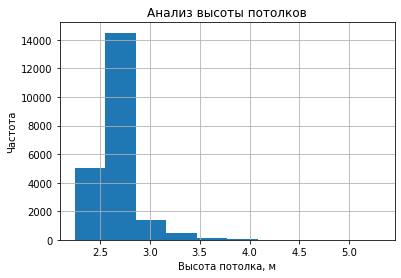

In [82]:
df['ceiling_height'].hist()
plt.title('Анализ высоты потолков')
plt.xlabel('Высота потолка, м')
plt.ylabel('Частота');

In [83]:
df['ceiling_height'].describe()

count    21609.000000
mean         2.703773
std          0.194165
min          2.250000
25%          2.570000
50%          2.700000
75%          2.760000
max          5.300000
Name: ceiling_height, dtype: float64

- наиболее распространенная высота потолка - 2,5 -2,8- это стандартная высота потолка, соответствующая нормам строительства
- максимальная высота - 5,3м. Посчитаем это нормой. На этапе подготовки данных значения в районе 5м не были удалены, так как в интернете встречались такие объявления в элитных новостройках Санкт-Петербурга. 

##### Анализ этажа квартиры 'floor', типа этажа(первый,последний,другой) 'floor_type', общего количества этажей в доме 'floors_total'

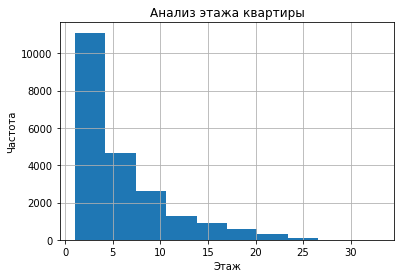

In [84]:
df['floor'].hist()
plt.title('Анализ этажа квартиры')
plt.xlabel('Этаж')
plt.ylabel('Частота');

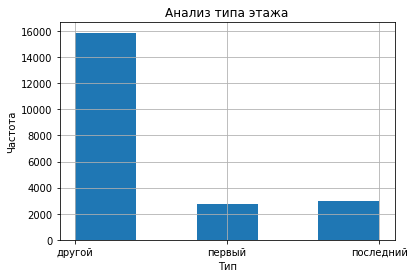

In [85]:
df['floor_type'].hist(bins=5)
plt.title('Анализ типа этажа')
plt.xlabel('Тип')
plt.ylabel('Частота');

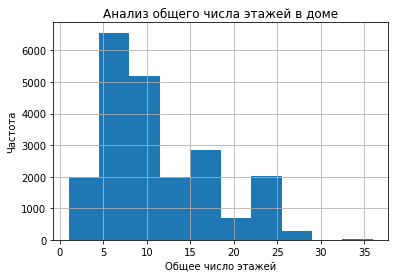

In [86]:
df['floors_total'].hist()
plt.title('Анализ общего числа этажей в доме')
plt.xlabel('Общее число этажей')
plt.ylabel('Частота');

In [87]:
df['floors_total'].describe()

count    21609.000000
mean        10.729557
std          6.592686
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         36.000000
Name: floors_total, dtype: float64

- большинство объявлений приходится на квартиры в 5-и и 9-и и 16-и-этажных домах, расположенных, в основном, не на первом и не на последнем этаже. 
- квартиры в одноэтажных домах - скорее всего дома в поселках и деревнях, аномалии нет (ниже выведен список одноэтажных квартир по населенным пунктам, подтверждающий наши предположения)
- есть квартиры в домах с 36 этажами. Согласно информации из интернета, такие многоэтажки действительно есть в Санкт-Петербурге.

In [88]:
df.query('floors_total==1')['locality_name'].value_counts()#посмотрим на объявления с одноэтажными домами

Санкт-Петербург                          2
Сестрорецк                               2
Луга                                     2
поселок городского типа Рощино           2
поселок Оредеж                           1
поселок городского типа Ефимовский       1
городской поселок Будогощь               1
деревня Большие Колпаны                  1
Высоцк                                   1
Волосово                                 1
поселок Пчевжа                           1
деревня Сижно                            1
поселок Суйда                            1
поселок Сосново                          1
деревня Каськово                         1
поселок Стрельна                         1
поселок городского типа Большая Ижора    1
Зеленогорск                              1
поселок Гаврилово                        1
городской поселок Свирьстрой             1
Name: locality_name, dtype: int64

##### Анализ расстояний до центра города, до ближайшего аэропорта, до ближайшего парка 'city_centers_nearest', 'airports_nearest', 'parks_nearest'

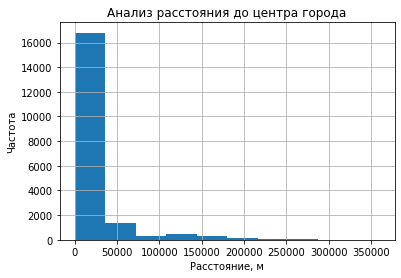

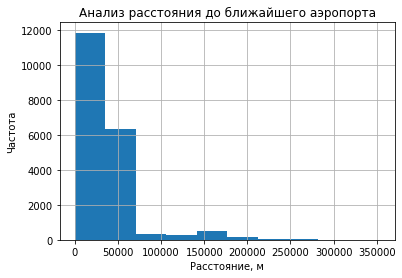

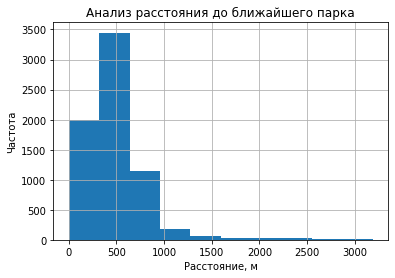

In [89]:
fig1 = plt.figure(1)
ax1 = fig1.subplots()
ax1.hist(df['city_centers_nearest'])
ax1.set_xlabel('Расстояние, м')
ax1.set_ylabel('Частота')
plt.grid(True)
ax1.set_title('Анализ расстояния до центра города')

fig2 = plt.figure(2)
ax2 = fig2.subplots()
ax2.hist(df['airports_nearest'])
ax2.set_xlabel('Расстояние, м')
ax2.set_ylabel('Частота') 
plt.grid(True)
ax2.set_title('Анализ расстояния до ближайшего аэропорта')

fig3 = plt.figure(3)
ax3 = fig3.subplots()
ax3.hist(df['parks_nearest'])
ax3.set_xlabel('Расстояние, м')
ax3.set_ylabel('Частота')
plt.grid(True)
ax3.set_title('Анализ расстояния до ближайшего парка')

plt.show()

In [90]:
df[['city_centers_nearest','airports_nearest','parks_nearest']].describe()

,city_centers_nearest,airports_nearest,parks_nearest
count,19542.000000,19542.000000,6930.000000
mean,26039.661402,38235.754145,491.386291
std,36395.487515,34762.483809,331.902078
min,208.000000,0.000000,1.000000
25%,11101.250000,19564.750000,293.000000
50%,14657.500000,30742.000000,458.000000
75%,23485.250000,43250.000000,614.000000
max,360000.000000,353000.000000,3190.000000


Из приведенных выше гистограмм делаем выводы:
- в среднем расстояние до центра города находится в интервале 10-20км(это норма, учитывая размеры Санкт-Петербурга), есть и минимум 208 м, максимальное расстояние - 360 км, скорее всего это деревня или поселок в Ленинградской области
- данных о ближайших парках немного. В основном парки находятся в пределах 250-650м от продаваемого объекта недвижимости.

##### Анализ дня и месяца публикации объявления 'weekday', 'month'

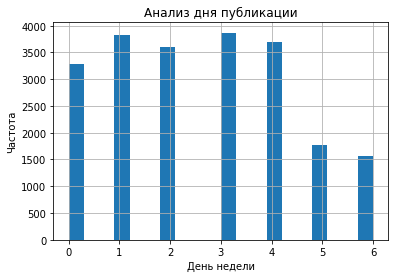

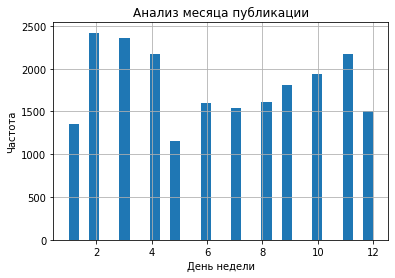

In [91]:
fig1 = plt.figure(1)
ax1 = fig1.subplots()
ax1.hist(df['weekday'], bins = 20)
ax1.set_xlabel('День недели')
ax1.set_ylabel('Частота')
ax1.set_title('Анализ дня публикации')
plt.grid(True)

fig2 = plt.figure(2)
ax2 = fig2.subplots()
ax2.hist(df['month'], bins = 30)
ax2.set_xlabel('День недели')
ax2.set_ylabel('Частота')
ax2.set_title('Анализ месяца публикации')
plt.grid(True)

plt.show()

Из приведенных выше гистограмм следует:
- в будние дни объявления публиковались чаще, нежели в выходные
- большинство публикаций приходится на промежутки времени февраль-апрель, октябрь-ноябрь

#### Изучим, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление.

In [92]:
df['days_exposition'].describe()

count    18888.000000
mean       175.839792
std        214.752653
min          1.000000
25%         44.000000
50%         93.000000
75%        223.000000
max       1580.000000
Name: days_exposition, dtype: float64

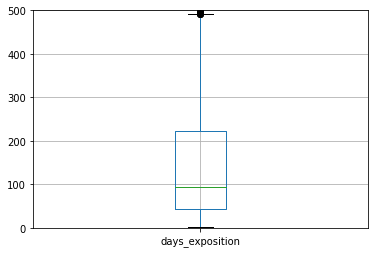

In [93]:
plt.ylim(0,500)
df.boxplot('days_exposition');

- в среднем, срок продажи квартиры составляет 3 месяца,
- минимум- 1 день(возможно,передумали продавать,либо нашли ошибку и создали новое объявление), максимум - 4 года (черезвычайно долго)
- сверхбыстрыми продажами будем считать объявления с длительностью в 1 день ; необычайно долгими - более 500 дней(выше верхнего 'уса')

<AxesSubplot:>

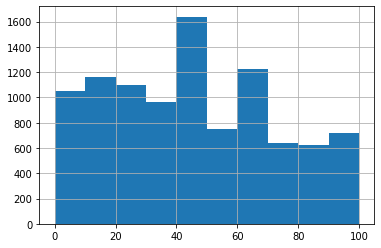

In [94]:
df['days_exposition'].hist(range=(0,100));

#### Анализ факторов, влияющих на полную стоимость объекта

##### Зависимость цены квартиры от ее общей площади

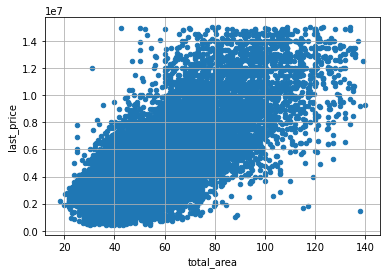

In [95]:
df.plot(x='total_area', y='last_price', kind = 'scatter', grid=True, title='');

In [96]:
df['last_price'].corr(df['total_area'])

0.7386986399198232

Коэффициент корреляции Пирсона между стоимостью квартиры и ее общей площадью достаточно большой. На диаграмме рассеяния также видна линейная зависимость исследуемых признаков. Делаем вывод: стоимость квартиры и ее общая площадь тесно взаимосвязаны.

##### Зависимость стоимости от жилой площади квартиры

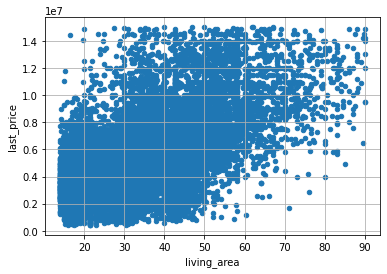

In [97]:
df.plot(x='living_area', y='last_price', kind = 'scatter', grid=True);

In [98]:
df['last_price'].corr(df['living_area'])

0.6173925625968457

Коэффициент корреляции Пирсона между стоимостью квартиры и ее жилой площадью так же высокий. Это говорит о достаточной зависимости стоимости квартиры от жилой площади.

##### Зависимость стоимости квартиры от площади кухни 

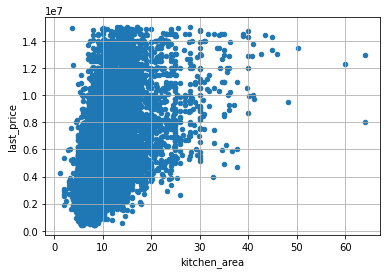

In [99]:
df.plot(x='kitchen_area', y='last_price', kind = 'scatter', grid=True);

In [100]:
df['last_price'].corr(df['kitchen_area'])

0.5418774919386123

Зависимость стоимости квартиры от площади кухни уже не такая высокая, как, например, от общей площади квартиры, но все же она заметная. Это следует и из диаграммы рассеяния, и из коэффициента корреляции Пирсона.

##### Зависимость стоимости от числа комнат квартиры

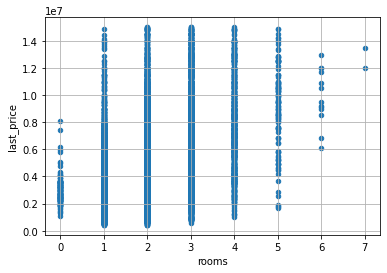

In [101]:
df.plot(x='rooms', y='last_price', kind = 'scatter', grid=True);

In [102]:
df['last_price'].corr(df['rooms'])

0.4623109251833513

Коэффициент корреляции Пирсона уже ближе к нулю, нежели к единице. Это говорит об умеренной зависимости стоимости квартиры от числа комнат.

##### Зависимость стоимости квартиры от типа этажа (первый, последний, другой)

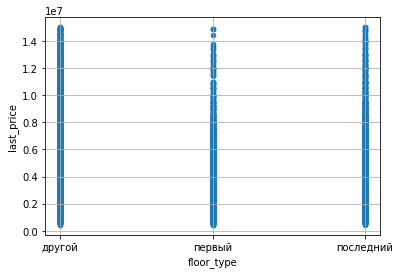

In [103]:
df.plot(x='floor_type', y='last_price', kind = 'scatter', grid=True);

In [104]:
df.query('floors_total<=9').pivot_table(index='floors_total', columns='floor_type', values='last_price', aggfunc='median')

floor_type,другой,первый,последний
floors_total,,,
1,NaN,2150000.0,NaN
2,NaN,1920000.0,2000000.0
3,3850000.0,3210000.0,3500000.0
4,5600000.0,4375000.0,5599000.0
5,3650000.0,3470000.0,3600000.0
6,7250000.0,5100000.0,5700000.0
7,6900000.0,4995000.0,5900000.0
8,5690000.0,4075000.0,5650000.0
9,4450000.0,4262500.0,4300000.0


Из сводной таблицы по этжам делаем вывод, что первые этажи дешевле остальных, последние этажи также чуть дешевле других. Но они не самые популярные.

##### Зависимость стоимости квартиры от даты публикации

In [105]:
df_weekday = df.pivot_table( index='weekday', values='last_price' )

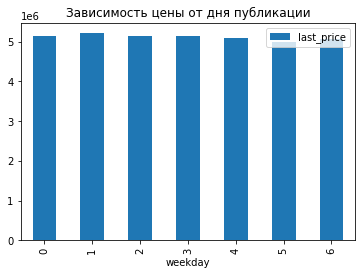

In [106]:
df_weekday.plot.bar(title='Зависимость цены от дня публикации');

Из графика следует, что стоимость квартиры не зависит от дня публикации: во все дни цена примерно одинаковая

In [107]:
df_month = df.pivot_table( index='month', values='last_price' )

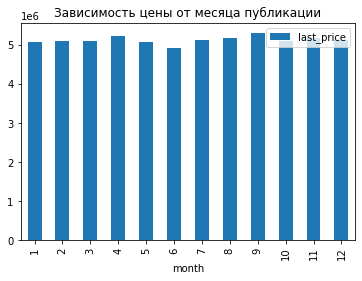

In [108]:
df_month.plot.bar(title='Зависимость цены от месяца публикации');

Цены чуть ниже в июне, в апреле и сентябре максимальны. В целом, стоимость квартир не сильно различается в зависимости от месяца продажи.

In [109]:
df_year = df.pivot_table( index='year', values='last_price' )

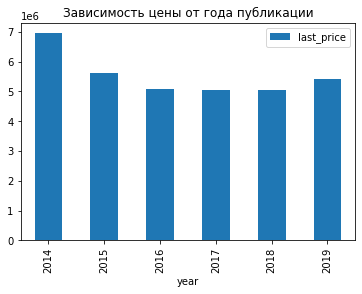

In [110]:
df_year.plot.bar(title='Зависимость цены от года публикации');

в 2015 году цены на квартиры снизились более чем на миллион, и продолжали снижаться до 2019 года, в 2019м году средняя стоимость квартир снова выросла, примерно на полмиллиона рублей.

#### Расчет средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [111]:
df_price = df.pivot_table(index='locality_name', values='price_meter', aggfunc=['count','mean'])
df_price.columns = ['count','price_meter_mean']# переименовываем мультииндексы в столбцах
df_price = df_price.sort_values(by='count', ascending=False).head(10)#список 10-ти нас.пунктов с самым большим числом объявлений
df_price.sort_values(by='price_meter_mean',ascending=False)#отсортированный список по цене за квадратный метр

,count,price_meter_mean
locality_name,,
Санкт-Петербург,14012,107007.842017
Пушкин,344,101077.625698
деревня Кудрово,286,92459.145979
поселок Парголово,305,89717.319672
поселок Мурино,509,84982.358566
поселок Шушары,422,77688.023365
Колпино,334,75358.928832
Гатчина,300,68798.263933
Всеволожск,378,67142.397725


Самая высокая цена за квадратный метр - в Санкт-Петербурге (ожидаемо), самая низкая - в Выборге.

#### Определение средней цены  квартир в Санкт-Петербурге на каждый километр 

In [112]:
# сводная таблица для цен на квартиры в зависимости от расстояния до центра
df_centers = df.query('locality_name=="Санкт-Петербург"').pivot_table(index='centers', values='last_price')
df_centers

,last_price
centers,
0.0,9.248333e+06
1.0,9.263213e+06
2.0,8.826049e+06
3.0,8.107336e+06
4.0,8.375077e+06
5.0,8.358259e+06
6.0,7.830732e+06
7.0,7.189178e+06
8.0,7.128288e+06


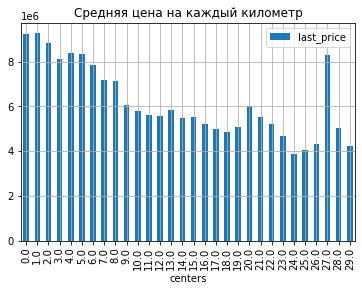

In [113]:
df_centers.plot.bar(title='Средняя цена на каждый километр')
plt.grid(True);

 Вывод: чем ближе к центру, тем квартиры дороже. Исходя из графика определим центральную зону радиусом в 8 км, вне этой зоны цены на недвижимость ощутимо ниже.

### Общий вывод

В процессе исследования была проведена предобработка данных:
   - выявлены аномальные значения и выбросы;
   - заполнены пропуски там, где это возможно, в том числе с использованием Яндекс.Карты;
   - изменены типы данных на типы, соответствующие значениям.
   
В результате исследования были получены следующие данные: 
   - самыми популярными в продаже являются **1,2,3 -комнатные квартиры общей площадью 40-65 кв м, стоимостью 3-7 млн руб;**
   - квартиры на первом и последним этажах - дешевле остальных, но менее популярны;
   - **средний срок продажи квартиры - 3 месяца**, сверхбыстрой будем считать продажу за 1 день. необычайно долгой - выше 500 дней;
   - самые дорогие (из наибольшего количества объявлений) квартиры -**в Санкт-Петербурге -115 тыс руб/кв м**, самые дешевые - **в    Выборге 58 тыс руб/кв м**
   - кроме того, на рынке недвижимости присутствуют элитные квартиры площадью до 900 кв м стоимостью до 800 млн руб. Рынок элитной недвижимости можно изучить отдельно.
   
В результате исследования были выявлены следующие факторы, влияющие на стоимость квартир:
   - общая плошадь
   - жилая площадь
   - площадь кухни
   - число комнат
   - тип этажа
   - удаленность от центра города
   - год продажи